In [ ]:
pip install hopsworks

In [ ]:
import numpy as np # linear algebra
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [ ]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.
Connection closed.
Copy your Api Key (first register/login): https://c.app.hopsworks.ai/account/api/generated

Paste it here: ··········
Connected. Call `.close()` to terminate connection gracefully.

Multiple projects found. 

	 (1) ID2223_lab1
	 (2) moahof00

Enter project to access: ID2223_lab1
Invalid input, should be an integer from the list of projects.

Enter project to access: 1

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/4247


Connected. Call `.close()` to terminate connection gracefully.


In [ ]:
electricity_data_fg = fs.get_or_create_feature_group(
    name = 'electricity_data_fg',
    version = 1
)

In [ ]:
electricity_data_fg = fs.get_feature_group('electricity_data_fg', version=1)

In [ ]:
electricity_data_fg.read()

,hydro_water_reservoir,nuclear,other,solar,wind_onshore,datetime,day_ahead_price,total_load,temperature
0,419.0,4545.0,296.0,0.0,268.0,1662346800000,210.00,7128.0,12.1
1,1037.0,4769.0,741.0,204.0,1451.0,1652263200000,144.90,9570.0,12.1
2,668.0,6917.0,770.0,257.0,354.0,1650117600000,34.61,8206.0,10.8
3,1050.0,5583.0,491.0,0.0,178.0,1653253200000,180.84,8276.0,10.3
4,1025.0,5486.0,571.0,0.0,1812.0,1650744000000,37.93,9022.0,10.6
...,...,...,...,...,...,...,...,...,...
6645,1035.0,5796.0,882.0,0.0,2289.0,1672844400000,80.82,13773.0,3.9
6646,803.0,5795.0,867.0,0.0,377.0,1672786800000,82.88,11071.0,2.8
6647,1043.0,5795.0,883.0,0.0,2256.0,1672840800000,79.74,13708.0,3.8
6648,1064.0,5795.0,909.0,2.0,2139.0,1672833600000,79.72,13539.0,3.1


,hydro_water_reservoir,nuclear,other,solar,wind_onshore,datetime,day_ahead_price,total_load,temperature
0,419.0,4545.0,296.0,0.0,268.0,1662346800000,210.00,7128.0,12.1
1,1037.0,4769.0,741.0,204.0,1451.0,1652263200000,144.90,9570.0,12.1
2,668.0,6917.0,770.0,257.0,354.0,1650117600000,34.61,8206.0,10.8
3,1050.0,5583.0,491.0,0.0,178.0,1653253200000,180.84,8276.0,10.3
4,1025.0,5486.0,571.0,0.0,1812.0,1650744000000,37.93,9022.0,10.6
...,...,...,...,...,...,...,...,...,...
6645,1035.0,5796.0,882.0,0.0,2289.0,1672844400000,80.82,13773.0,3.9
6646,803.0,5795.0,867.0,0.0,377.0,1672786800000,82.88,11071.0,2.8
6647,1043.0,5795.0,883.0,0.0,2256.0,1672840800000,79.74,13708.0,3.8
6648,1064.0,5795.0,909.0,2.0,2139.0,1672833600000,79.72,13539.0,3.1


In [ ]:
query = electricity_data_fg.select_all()

In [ ]:
query_show = electricity_data_fg.show(5)
col_names = query_show.columns


In [ ]:
category_cols = ['datetime']
mapping_transformers = {col_name:fs.get_transformation_function(name='standard_scaler') for col_name in col_names if col_name not in category_cols}


In [ ]:
feature_view = fs.create_feature_view(
    name = 'electricity_data_fv',
    version = 3,
    #transformation_functions = mapping_transformers,
    query = query
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/4247/fs/4192/fv/electricity_data_fv/version/3


In [ ]:
version, job = feature_view.create_training_data(
    description = 'electricity price pred train data',
    data_format = 'csv',
    write_options = {"wait_for_job": False}
) # By default, it is materialised to HopsFS
print(job.id) 

Training dataset job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/4247/jobs/named/electricity_data_fv_3_1_create_fv_td_06012023180553/executions
16485


In [ ]:
train_data = feature_view.get_training_data(training_dataset_version=1)[0]

In [ ]:
train_data

,hydro_water_reservoir,nuclear,other,solar,wind_onshore,datetime,day_ahead_price,total_load,temperature
0,419.0,4545.0,296.0,0.0,268.0,1662346800000,210.00,7128.0,12.1
1,1037.0,4769.0,741.0,204.0,1451.0,1652263200000,144.90,9570.0,12.1
2,668.0,6917.0,770.0,257.0,354.0,1650117600000,34.61,8206.0,10.8
3,1050.0,5583.0,491.0,0.0,178.0,1653253200000,180.84,8276.0,10.3
4,1025.0,5486.0,571.0,0.0,1812.0,1650744000000,37.93,9022.0,10.6
...,...,...,...,...,...,...,...,...,...
6645,1035.0,5796.0,882.0,0.0,2289.0,1672844400000,80.82,13773.0,3.9
6646,803.0,5795.0,867.0,0.0,377.0,1672786800000,82.88,11071.0,2.8
6647,1043.0,5795.0,883.0,0.0,2256.0,1672840800000,79.74,13708.0,3.8
6648,1064.0,5795.0,909.0,2.0,2139.0,1672833600000,79.72,13539.0,3.1


In [ ]:
new_data = pd.to_datetime(train_data['datetime'])

AttributeError: ignored

In [ ]:
new_data

0      1970-01-01 00:27:42.346800
1      1970-01-01 00:27:32.263200
2      1970-01-01 00:27:30.117600
3      1970-01-01 00:27:33.253200
4      1970-01-01 00:27:30.744000
                  ...            
6645   1970-01-01 00:27:52.844400
6646   1970-01-01 00:27:52.786800
6647   1970-01-01 00:27:52.840800
6648   1970-01-01 00:27:52.833600
6649   1970-01-01 00:27:52.837200
Name: datetime, Length: 6650, dtype: datetime64[ns]

In [ ]:
train_data.set_index('datetime', inplace=True)

In [ ]:
train_data

,hydro_water_reservoir,nuclear,other,solar,wind_onshore,day_ahead_price,total_load,temperature
datetime,,,,,,,,
1662346800000,419.0,4545.0,296.0,0.0,268.0,210.00,7128.0,12.1
1652263200000,1037.0,4769.0,741.0,204.0,1451.0,144.90,9570.0,12.1
1650117600000,668.0,6917.0,770.0,257.0,354.0,34.61,8206.0,10.8
1653253200000,1050.0,5583.0,491.0,0.0,178.0,180.84,8276.0,10.3
1650744000000,1025.0,5486.0,571.0,0.0,1812.0,37.93,9022.0,10.6
...,...,...,...,...,...,...,...,...
1672844400000,1035.0,5796.0,882.0,0.0,2289.0,80.82,13773.0,3.9
1672786800000,803.0,5795.0,867.0,0.0,377.0,82.88,11071.0,2.8
1672840800000,1043.0,5795.0,883.0,0.0,2256.0,79.74,13708.0,3.8


In [ ]:
train_size = int(len(train_data) * 0.80)
test_size = len(train_data) - train_size
test = train_data.iloc[train_size:,:]
train = train_data.iloc[0:train_size,:]

In [ ]:
train

,hydro_water_reservoir,nuclear,other,solar,wind_onshore,day_ahead_price,total_load,temperature
datetime,,,,,,,,
1662346800000,419.0,4545.0,296.0,0.0,268.0,210.00,7128.0,12.1
1652263200000,1037.0,4769.0,741.0,204.0,1451.0,144.90,9570.0,12.1
1650117600000,668.0,6917.0,770.0,257.0,354.0,34.61,8206.0,10.8
1653253200000,1050.0,5583.0,491.0,0.0,178.0,180.84,8276.0,10.3
1650744000000,1025.0,5486.0,571.0,0.0,1812.0,37.93,9022.0,10.6
...,...,...,...,...,...,...,...,...
1644616800000,1264.0,6982.0,804.0,0.0,2214.0,73.46,11605.0,3.0
1660593600000,655.0,5484.0,242.0,3.0,773.0,279.99,8549.0,19.7
1653307200000,954.0,5582.0,662.0,322.0,302.0,180.86,9370.0,19.1


In [ ]:
sc_x=StandardScaler()
X_scaled_train=sc_x.fit_transform(train)

In [ ]:
sc_y=StandardScaler()
y_scaled_train=sc_y.fit_transform(train[['day_ahead_price']])

In [ ]:
step_back=25
no_records=5320
no_cols=8
X_train=[]
y_train=[]
for i in range(25,5230):
    X_train.append(X_scaled_train[i-25:i])
    y_train.append(y_scaled_train[i][0])
X_train,y_train=np.array(X_train),np.array(y_train)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(5205, 25, 8)
(5205,)


In [ ]:
X_train_shape=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],X_train.shape[2]))

In [ ]:
X_train_shape.shape

(5205, 25, 8)

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(100, input_shape=(25,8)))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               43600     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 43,701
Trainable params: 43,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm.fit(X_train_shape, y_train, epochs=200, batch_size=265, verbose=1, shuffle=False)

Epoch 1/200
20/20 [==============================] - 3s 56ms/step - loss: 1.0020
Epoch 2/200
20/20 [==============================] - 1s 56ms/step - loss: 0.9986
Epoch 3/200
20/20 [==============================] - 1s 54ms/step - loss: 0.9949
Epoch 4/200
20/20 [==============================] - 1s 56ms/step - loss: 0.9931
Epoch 5/200
20/20 [==============================] - 1s 55ms/step - loss: 0.9909
Epoch 6/200
20/20 [==============================] - 1s 56ms/step - loss: 0.9911
Epoch 7/200
20/20 [==============================] - 1s 57ms/step - loss: 0.9909
Epoch 8/200
20/20 [==============================] - 1s 55ms/step - loss: 0.9868
Epoch 9/200
20/20 [==============================] - 1s 54ms/step - loss: 0.9877
Epoch 10/200
20/20 [==============================] - 1s 56ms/step - loss: 0.9808
Epoch 11/200
20/20 [==============================] - 1s 55ms/step - loss: 0.9850
Epoch 12/200
20/20 [==============================] - 1s 54ms/step - loss: 0.9767
Epoch 13/200
20/20 [=====

KeyboardInterrupt: ignored

In [ ]:
last_25=train.iloc[-25:]
full_df= pd.concat((last_25,test),axis=0)
print(full_df.shape)
full_df.head()

(1355, 8)


,hydro_water_reservoir,nuclear,other,solar,wind_onshore,day_ahead_price,total_load,temperature
datetime,,,,,,,,
1664467200000,601.0,4629.0,623.0,60.0,477.0,242.84,9048.0,9.7
1648926000000,1068.0,6966.0,882.0,2.0,728.0,89.90,10978.0,1.8
1642870800000,1321.0,6920.0,1283.0,0.0,780.0,222.31,13170.0,3.1
1646488800000,1010.0,6673.0,1121.0,93.0,989.0,59.79,10839.0,3.7
1660568400000,701.0,5493.0,330.0,320.0,662.0,278.54,9289.0,28.2


In [ ]:
full_df=sc_x.transform(full_df)
full_df.shape

(1355, 8)

In [ ]:
step_back=25
no_records=1355
no_cols=8
X_train_shape_pred=[]
for i in range(25,1355):
    X_train_shape_pred.append(full_df[i-25:i])
X_train_shape_pred=np.array(X_train_shape_pred)
print(X_train_shape_pred.shape)

(1330, 25, 8)


In [ ]:
y_test=model.predict(X_train_shape_pred)

42/42 [==============================] - 0s 4ms/step


In [ ]:
y_final_pred=sc_y.inverse_transform(y_test)
y_final_pred

array([[161.30675],
       [ 83.68476],
       [ 86.21842],
       ...,
       [303.7445 ],
       [266.81345],
       [320.69357]], dtype=float32)

In [ ]:
final_pred=pd.DataFrame(y_final_pred)
final_pred.columns=['final_pred']
final_pred

,final_pred
0,161.306747
1,83.684761
2,86.218422
3,120.202209
4,195.071533
...,...
1325,221.315033
1326,251.570343
1327,303.744507
1328,266.813446


In [ ]:
test.reset_index(inplace=True)

In [ ]:
fully_final=pd.concat((final_pred,test),axis=1)
fully_final

,final_pred,index,datetime,hydro_water_reservoir,nuclear,other,solar,wind_onshore,day_ahead_price,total_load,temperature
0,161.306747,0,1653411600000,661.0,5557.0,520.0,88.0,1539.0,100.06,9407.0,14.0
1,83.684761,1,1657965600000,325.0,5157.0,305.0,273.0,915.0,1.50,7240.0,19.8
2,86.218422,2,1661688000000,638.0,5411.0,261.0,111.0,1339.0,113.20,8203.0,19.3
3,120.202209,3,1642345200000,748.0,6977.0,881.0,0.0,2317.0,17.51,11869.0,6.6
4,195.071533,4,1651096800000,1302.0,5394.0,756.0,0.0,234.0,199.97,9934.0,8.4
...,...,...,...,...,...,...,...,...,...,...,...
1325,221.315033,1325,1672844400000,1035.0,5796.0,882.0,0.0,2289.0,80.82,13773.0,3.9
1326,251.570343,1326,1672786800000,803.0,5795.0,867.0,0.0,377.0,82.88,11071.0,2.8
1327,303.744507,1327,1672840800000,1043.0,5795.0,883.0,0.0,2256.0,79.74,13708.0,3.8
1328,266.813446,1328,1672833600000,1064.0,5795.0,909.0,2.0,2139.0,79.72,13539.0,3.1


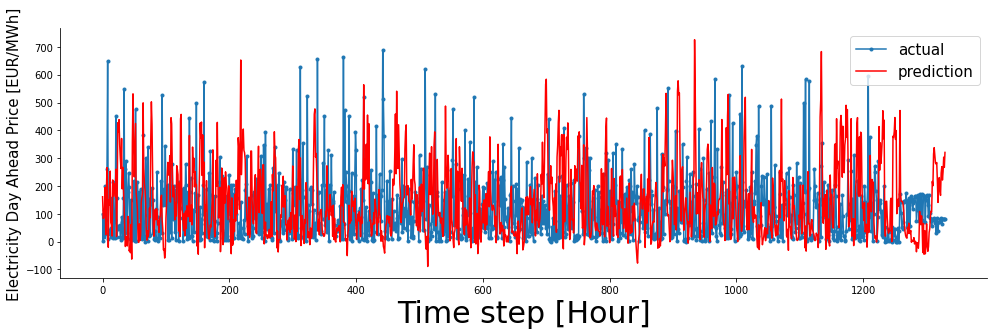

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
aa=[x for x in range(1330)]
plt.figure(figsize=(14,4))
plt.plot(aa, fully_final['day_ahead_price'], marker='.', label="actual")
plt.plot(aa, fully_final['final_pred'], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Electricity Day Ahead Price [EUR/MWh]', size=15)
plt.xlabel('Time step [Hour]', size=30)
plt.legend(fontsize=15)
plt.show();